In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.io.wavfile as wavfile
from scipy.signal import spectrogram
from scipy.fftpack import fft
from pydub import AudioSegment
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import librosa
from scipy.stats import zscore
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

/opt/homebrew/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
dev_path = 'dsl_data/development.csv'
eval_path = 'dsl_data/evaluation.csv'


In [3]:
def load_dataframe(path):
    df = pd.read_csv(path)
    # Dataframe exploration
    print('***** DATAFRAME INFO *****\n')
    print(df.info())
    print('\n\n***** HEAD *****\n')
    print(df.head())
    print('\n\n ***** POSSIBLE CLASSIFICATION OUTCOMES *****\n')
    #print(df.groupby(['action', 'object']).size())
    sampleRates = list()
    audios = list()
    for i in range(0, df.shape[0]):
        audio_path = df['path'].loc[i]
        sampleRates.append(get_sample_rate(audio_path))
        audios.append(get_audio_data(audio_path))
    df['SampleRates'] = sampleRates
    df['AudioData'] = audios
    print('\n\n ***** SAMPLE RATES *****')
    print(df.groupby(['SampleRates']).size())
    
    print('\n\n ***** Self-reported fluency level *****')
    print(df.groupby(['Self-reported fluency level ']).size())
    
    print('\n\n ***** First Language spoken *****')
    print(df.groupby(['First Language spoken']).size())
    
    print('\n\n ***** Current language used for work/school *****')
    print(df.groupby(['Current language used for work/school']).size())
    
    print('\n\n ***** Gender *****')
    print(df.groupby(['gender']).size())
    print('\n\n ***** Age range *****')
    print(df.groupby(['ageRange']).size())
    return df

def get_sample_rate(filepath):
    sr, audio = wavfile.read(filepath)
    return sr

def get_audio_data(filepath):
    sr, audio = wavfile.read(filepath)
    return audio


def edit_sample_rates(df, goal_sr):
    for index, row in df.iterrows():
    # Load the audio file
        audio = AudioSegment.from_file(row['path'])
    # Check if the sample rate is different from the target sample rate
        if audio.frame_rate != goal_sr:
            # Convert the sample rate to the target sample rate
            audio = audio.set_frame_rate(goal_sr)
            # get file format
            file_format = os.path.splitext(row['path'])[1][1:]
            # Save the converted audio
            audio.export(row['path'], format=file_format)
    sampleRates = list()
    for i in range(0, df.shape[0]):
        audio_path = df['path'].loc[i]
        sampleRates.append(get_sample_rate(audio_path))
    df['SampleRates'] = sampleRates
    print(df.groupby(['SampleRates']).size())

# definition of functions to represent each audio 

def plot_spectrogram(audio_data, sr):
    frequencies, times, spec = spectrogram(audio_data, fs=sr)
    plt.pcolormesh(times, frequencies, 10*np.log10(spec)) #changed the scale to dB
    plt.colorbar()
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()
    return spec, len(audio)


def plot_time_dimension(audio_data, sr):
    audioArray = np.array(audio_data)
    duration = len(audio) / sr
    # Create the time axis in seconds
    time = np.linspace(0, duration, len(audio))
    plt.plot(time, audioArray)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
def plot_freq_dimension(audio_data, sr):
    audioArray = np.array(audio_data)
    freqArray = np.abs(fft(audioArray))
    decibels = 20 * np.log10(freqArray)
    plt.figure(figsize=(10,4))
    plt.plot(decibels)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.show()
    

def encode_categorical(df):
    #ordinal encoding of categorical features
    catFeatures = ['Self-reported fluency level ', 'First Language spoken', 'Current language used for work/school', 'gender', 'ageRange']
    dicts = list()
    dic_fluency = {'native' : 0, 'advanced' : 1, 'intermediate':2, 'basic': 3}
    dicts.append(dic_fluency)
    dic_first_lan = {'English (United States)': 0, 'English (Canada)': 1, 'French (Canada)' : 2, 'Spanish (Venezuela)':3, 'Telugu':4 }
    dicts.append(dic_first_lan)
    dic_current = {'English (United States)': 0, 'English (Canada)': 1, 'English (Australia)' : 2, 'Spanish (Venezuela)':3 }
    dicts.append(dic_current)
    dic_gender = {'female': 0, 'male': 1 }
    dicts.append(dic_gender)
    dic_age = {'22-40':0, '41-65':1, '65+': 3}
    dicts.append(dic_age)
    for i in range(0, len(catFeatures)):
        dic = dicts[i]
        feat = catFeatures[i]
        df[feat] = df[feat].replace(dic)
    return df

In [5]:
df = load_dataframe(dev_path)

***** DATAFRAME INFO *****

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9854 entries, 0 to 9853
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Id                                     9854 non-null   int64 
 1   path                                   9854 non-null   object
 2   speakerId                              9854 non-null   object
 3   action                                 9854 non-null   object
 4   object                                 9854 non-null   object
 5   Self-reported fluency level            9854 non-null   object
 6   First Language spoken                  9854 non-null   object
 7   Current language used for work/school  9854 non-null   object
 8   gender                                 9854 non-null   object
 9   ageRange                               9854 non-null   object
dtypes: int64(1), object(9)
memory usage: 770.0+ KB
None


**

In [33]:
target_rate = 16000
edit_sample_rates(df, target_rate) #bring all sr's to 16kHz

SampleRates
16000    9854
dtype: int64


In [6]:
encode_categorical(df)

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,SampleRates,AudioData
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,1,0,0,0,0,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,1,0,0,0,0,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,1,0,0,0,0,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,1,0,0,0,0,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,1,0,0,0,0,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,0,0,0,1,0,16000,"[315, 321, 328, 335, 340, 342, 344, 351, 351, ..."
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,0,0,0,1,0,16000,"[320, 322, 327, 332, 334, 334, 336, 338, 343, ..."
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,0,0,0,1,0,16000,"[49, 52, 55, 59, 61, 65, 70, 73, 76, 81, 85, 8..."
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,0,0,0,1,0,16000,"[333, 339, 342, 344, 346, 349, 353, 355, 357, ..."


In [7]:
def plot_all_audios(df):
    fig, ax = plt.subplots(1,1)
    for ind in range(0, len(df)):
        audio = df['AudioData'].loc[ind]
        sr = df['SampleRates'].loc[ind]
        audioArray = np.array(audio)
        duration = len(audio) / sr
        time = np.linspace(0, duration, len(audio))
        ax.plot(time, audioArray)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time [s]")
    plt.show()
  

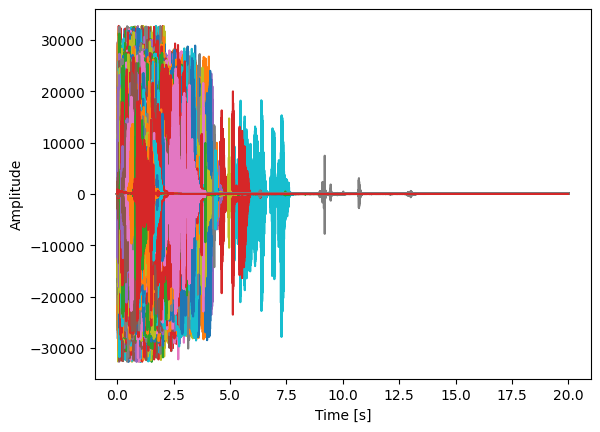

In [8]:
plot_all_audios(df)


In [7]:
# By normalising the amplitude of the audios it is possible 
#to lower the impact of different recording conditions:

def normalise_audios(df):
    normalised = list()
    for idx, rec in df.iterrows():
        normalised.append(zscore(rec['AudioData']))
    df['AudioData'] = normalised
    return df

In [8]:
df = normalise_audios(df)

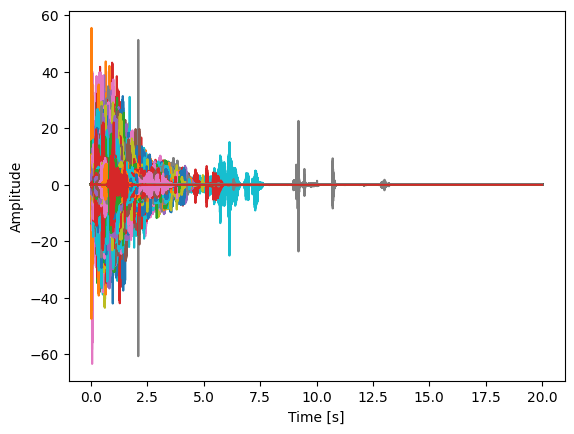

In [11]:
plot_all_audios(df)

In [14]:
def plot_duration_histogram(df):
    recList = []
    lenList = []

    for idx, row in df.iterrows():
        rec = row['AudioData']
        sr = row['SampleRates']
        recList.append(rec)
        lenList.append(len(rec)/sr)

    plt.xlabel('Seconds')
    plt.ylabel('Frequency')
    hist_array = plt.hist(np.array(lenList), bins='auto', color='#0504aa', alpha=0.7, rwidth=1)

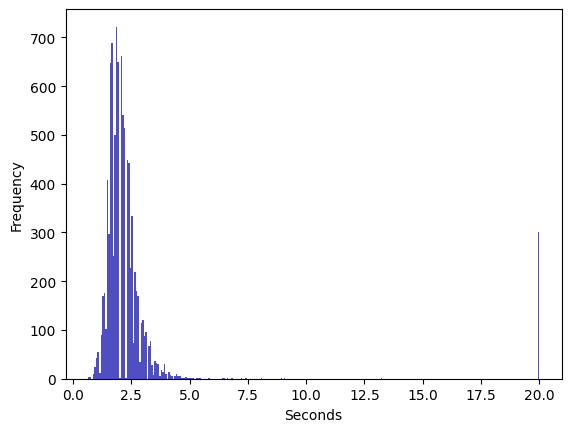

In [13]:
plot_duration_histogram(df)

In [9]:
def standardise_length(df, seconds):

    recListAdj = []
    lenListAdj = []

    for idx, row in df.iterrows():
        rec = row['AudioData']
        sr = row['SampleRates']
        rec, index = librosa.effects.trim(rec, top_db=30)
        threshold = sr * seconds 
        if len(rec) > threshold:
            rec = rec[:threshold]
        recListAdj.append(rec)
        lenListAdj.append(len(rec)/sr)
    df['AudioData'] = recListAdj
    return df

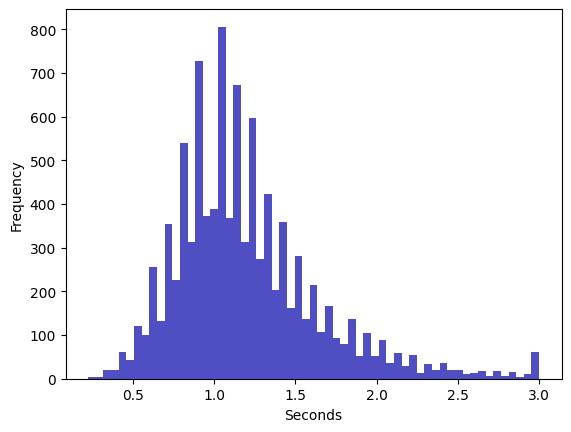

In [15]:
df = standardise_length(df, 3)
plot_duration_histogram(df)

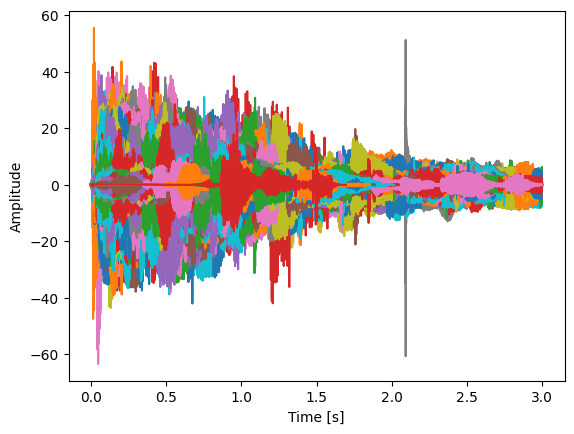

In [16]:
plot_all_audios(df)

In [11]:
def plot_split_spectrogram(audio, sr, n_blocks):
    frequencies, times, spec = spectrogram(audio, fs=sr)
    times = (times * 1000).astype(int) #milliseconds
    frequencies = frequencies.astype(int)
    fig, ax = plt.subplots(1,1)
    plt.pcolormesh(times, frequencies, 10*np.log10(spec)) #changed the scale to dB
    plt.colorbar()
    time_bounds = list()
    freq_bounds = list()
    #n_blocks is the same vertically and horizontally
    #starting from vertical lines to create time bins:
    v_step = int(times[len(times)-1] / n_blocks)
    
    for v in range(0, times[len(times)-1], v_step):
        ax.axvline(v, color = 'red')
        time_bounds.append(v)
    #and then horizontal lines to create frequency bins:
    h_step = int(frequencies[len(frequencies)-1]/n_blocks)
    for h in range(0, frequencies[len(frequencies)-1], h_step):
        ax.axhline(h, color = 'red')
        freq_bounds.append(h)
    plt.xlabel("Time (ms)")
    plt.xlim(left=0)
    plt.ylabel("Frequency (Hz)")
    plt.show()

def split_spectrogram(audio, sr, n_blocks):
    frequencies, times, spec = spectrogram(audio, fs=sr)
    times = (times * 1000).astype(int) #milliseconds
    frequencies = frequencies.astype(int)
        
    
    # Split the matrix into sub-arrays of size N along the first axis (rows)
    rows_blocks = np.array_split(spec, n_blocks, axis=0)
    #this is a list: each element of the list is a sub-matrix obtained slicing horizontally the spectrogram
    # into n_blocks slices

    # Split the sub_matrices into sub-arrays of size NxN along the second axis (columns)
    blocks = [ np.array_split(block, n_blocks, axis=1) for block in rows_blocks]
    #This is, instead, a list of lists: the first element is a list containing all the blocks obtained from 
    #the first vertical slice


    # Initialize arrays to store the mean and standard deviation of each block
    block_means = np.zeros((n_blocks,n_blocks))
    block_stds = np.zeros((n_blocks,n_blocks))

    

    # Iterate over blocks
    for i in range(0, n_blocks):
        for j in range(0, n_blocks):
            # Compute mean and standard deviation of the block
             #i is the index of the horizontal split  (indicating which column)
            block = blocks[i][j] #j is the index of the vertical split (indicating which row)
            mean = np.mean(block)
            std = np.std(block)
            minimum = np.min(block)
            maximum = np.max(block)
            block_means[i,j] = mean
            block_stds[i,j] = std
    return block_means.tolist(), block_stds.tolist(), blocks

In [16]:
#adding the statistics of the blocks into the dataframe

def add_stats_df(df,sr,n_blocks):
    for i in range(0,n_blocks):
        for j in range(0, n_blocks):
            idx = j+n_blocks*i
            col_name_mean = 'block_mean_'+str(idx)
            col_name_dev = 'block_dev_'+str(idx)
            df[col_name_mean] = ''
            df[col_name_dev] = ''
    all_means = list()
    all_std_devs = list()
    all_mins = list()
    all_maxs = list()

    for index, row in df.iterrows():
        audio = row['AudioData']
        meanTemp, stdTemp, blocksTemps = split_spectrogram(audio, sr, n_blocks)
        for i in range(0,n_blocks):
            for j in range(0, n_blocks):
                idx = j+n_blocks*i
                col_name_mean = 'block_mean_'+str(idx)
                col_name_dev = 'block_dev_'+str(idx)
                df.loc[index, col_name_mean] = meanTemp[i][j]
                df.loc[index, col_name_dev] = stdTemp[i][j]
        
   


In [17]:
label_dictionary = {'increase volume': 0, 'decrease volume': 1, 'increase heat': 2, 'decrease heat':3, 'change language none':4,'activate music':5, 'deactivate lights':6 }


In [18]:


# random forest hyperparameters:
RF_params = {
    'n_estimators' : [50, 100, 150, 200],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 10, 20, 50]
}



# Option 1 
For each possible number of blocks, search for the best hyperparameter configuration (this is super slow)

In [19]:
df1 = df.copy() #working every time with a new copy of the original df
n_blocks = range(2, 16, 2)
best_configs = list() #best configuration for each different number of blocks
best_accuracies = list() #higher accuracy for each different number of blocks
for n in n_blocks:
    print('# blocks: ', n)
    add_stats_df(df1, 16000, n)
    y = df1['action'] + ' ' + df1['object']
    y = y.replace(label_dictionary)
    X = df1.drop(['action', 'object', 'path', 'speakerId', 'AudioData'], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
    accuracies_rf = list()
    configs_rf = list()
    for config in ParameterGrid(RF_params):
        rf = RandomForestClassifier(**config)
        rf.fit(X_train, y_train)
        acc = accuracy_score(y_test, rf.predict(X_test))
        accuracies_rf.append(acc)
        configs_rf.append(config)
    max_val = max(accuracies_rf)
    max_idx = accuracies_rf.index(max_val)
    best_conf = configs_rf[max_idx]
    best_configs.append(best_conf)
    best_accuracies.append(max_val)
    print('The best accuracy for ', n, ' blocks is ', max_val , ' obtained with the configuration ', config)

best_acc = max(best_accuracies)    
best_idx = best_accuracies.index(best_acc)
best_tuning = best_configs[best_idx]
best_n = n_blocks[best_idx]
print('The best result in terms of accuracy is ', best_acc, ', obtained with n = ', best_n, ' and the configuration ', best_tuning )

# blocks:  2
The best accuracy for  2  blocks is  0.3419583967529173  obtained with the configuration  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}
# blocks:  4
The best accuracy for  4  blocks is  0.480466768138001  obtained with the configuration  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}
# blocks:  6
The best accuracy for  6  blocks is  0.5591070522577372  obtained with the configuration  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}
# blocks:  8
The best accuracy for  8  blocks is  0.604261796042618  obtained with the configuration  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}
# blocks:  10
The best accuracy for  10  blocks is  0.671740233384069  obtained with the configuration  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}
# blocks:  12
The best accuracy for  12  blocks is  0.6884830035514967  obtained with the configuration  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}
# b

# Option 2:
Look for the most accurate configuration without blocks (meaning only one block), then use that configuration to tune the number of blocks to used based on which one returns a higher accuracy (this is faster - the configuration returned is the same as before (entropy-50-200)

In [20]:
df2 = df.copy()

add_stats_df(df2, 16000, 1)
y = df2['action'] + ' ' + df2['object']
y = y.replace(label_dictionary)
X = df2.drop(['action', 'object', 'path', 'speakerId', 'AudioData'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
accuracies_rf = list()
configs_rf = list()

for config in ParameterGrid(RF_params):
    rf = RandomForestClassifier(**config)
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    accuracies_rf.append(acc)
    configs_rf.append(config)

max_val = max(accuracies_rf)
max_idx = accuracies_rf.index(max_val)
best_conf = configs_rf[max_idx]
print('The best accuracy is ', max_val , ' obtained with the configuration ', config)




The best accuracy is  0.313039066463724  obtained with the configuration  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 200}


In [21]:
n_blocks = range(2, 22, 2)
accuracies_rf_n = list()
for n in n_blocks:
    df2 = df.copy() #working every time with a new copy of the original df
    print('# blocks: ', n)
    add_stats_df(df2, 16000, n)
    y = df2['action'] + ' ' + df2['object']
    X = df2.drop(['action', 'object', 'path', 'speakerId', 'AudioData'], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
    rf = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators = 200)
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    accuracies_rf_n.append(acc)
    
max_val_n = max(accuracies_rf_n)
max_idx_n = accuracies_rf_n.index(max_val_n)
best_n = n_blocks[max_idx_n]
print('The best accuracy is ', max_val_n , ', obtained with n = ', best_n)

# blocks:  2
# blocks:  4
# blocks:  6
# blocks:  8
# blocks:  10
# blocks:  12
# blocks:  14
# blocks:  16


/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

In [22]:
#it still gives the same error with n = 16 ???
accuracies_rf_n

[0.3363774733637747,
 0.4682902080162354,
 0.5509893455098934,
 0.6047691527143582,
 0.6712328767123288,
 0.6839167935058346,
 0.6986301369863014]

In [23]:
# assuming the best result is obtained with criterion='entropy', max_depth=50, n_estimators = 200, n = 14:

n_blocks = 14
eval_df = load_dataframe(eval_path)


***** DATAFRAME INFO *****

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Id                                     1455 non-null   int64 
 1   path                                   1455 non-null   object
 2   speakerId                              1455 non-null   object
 3   Self-reported fluency level            1455 non-null   object
 4   First Language spoken                  1455 non-null   object
 5   Current language used for work/school  1455 non-null   object
 6   gender                                 1455 non-null   object
 7   ageRange                               1455 non-null   object
dtypes: int64(1), object(7)
memory usage: 91.1+ KB
None


***** HEAD *****

   Id                                               path          speakerId  \
0   0  dsl_data/audio/speakers/NgQEvO2x7V

In [24]:
X_train.head(20)

,Id,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,SampleRates,block_mean_0,block_dev_0,block_mean_1,...,block_mean_191,block_dev_191,block_mean_192,block_dev_192,block_mean_193,block_dev_193,block_mean_194,block_dev_194,block_mean_195,block_dev_195
3559,3559,0,0,0,1,0,16000,0.000966,0.003437,0.005358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8274,8274,0,0,0,0,1,16000,0.000686,0.001362,0.001413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000019,0.000071
5344,5344,0,0,0,1,0,16000,0.000012,0.000022,0.001968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,297,0,0,0,0,1,16000,0.000032,0.000073,0.004226,...,0.0,0.0,0.0,0.000001,0.000159,0.000274,0.000035,0.00005,0.000002,0.000005
1124,1124,0,0,0,1,1,16000,0.001,0.002902,0.003019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.000001
1460,1460,0,0,0,1,0,16000,0.0,0.0,0.004585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3271,3271,0,0,0,0,0,16000,0.000988,0.001162,0.00015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4764,4764,0,0,0,0,1,16000,0.000437,0.001181,0.001544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8058,8058,0,0,0,1,0,16000,0.001087,0.003524,0.000008,...,0.000004,0.000005,0.000001,0.000001,0.0,0.000001,0.0,0.0,0.0,0.0
9503,9503,0,0,0,0,1,16000,0.005892,0.019757,0.031482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001


In [25]:
eval_df.head()

,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,SampleRates,AudioData
0,0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d5...,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a...,V4ZbwLm9G5irobWn,native,English (United States),English (United States),female,41-65,16000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [26]:
target_rate = 16000
edit_sample_rates(eval_df, target_rate) #bring all sr's to 16kHz
encode_categorical(eval_df)
eval_df = normalise_audios(eval_df)
eval_df = standardise_length(eval_df, 3)
add_stats_df(eval_df, target_rate, n_blocks)


eval_X = eval_df.drop(['path', 'speakerId', 'AudioData'], axis = 1)

SampleRates
16000    1455
dtype: int64


In [27]:
eval_X.head()

,Id,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,SampleRates,block_mean_0,block_dev_0,block_mean_1,...,block_mean_191,block_dev_191,block_mean_192,block_dev_192,block_mean_193,block_dev_193,block_mean_194,block_dev_194,block_mean_195,block_dev_195
0,0,0,0,0,1,0,16000,0.000734,0.001809,0.004086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,1,0,16000,0.000838,0.004087,0.002369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,0,1,1,16000,0.000006,0.000011,0.003844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0,0,1,0,16000,0.000001,0.000003,0.004045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,0,0,1,16000,0.001288,0.00328,0.004587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
add_stats_df(df, 16000, 14)
y = df['action'] + ' ' + df['object']
y = y.replace(label_dictionary)
X = df.drop(['action', 'object', 'path', 'speakerId', 'AudioData'], axis = 1)

In [49]:
X.head()

,Id,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,SampleRates,block_mean_0,block_dev_0,block_mean_1,...,block_mean_191,block_dev_191,block_mean_192,block_dev_192,block_mean_193,block_dev_193,block_mean_194,block_dev_194,block_mean_195,block_dev_195
0,0,1,0,0,0,0,16000,0.000072,0.00028,0.004955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,0.000003,0.000001,0.000001
1,1,1,0,0,0,0,16000,0.00038,0.001109,0.004402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0,0,0,0,16000,0.001429,0.003511,0.000686,...,0.0,0.0,0.000019,0.000044,0.000028,0.000031,0.000012,0.000014,0.000002,0.000005
3,3,1,0,0,0,0,16000,0.000055,0.000091,0.000124,...,0.0,0.0,0.0,0.0,0.000013,0.000017,0.0,0.0,0.0,0.0
4,4,1,0,0,0,0,16000,0.001332,0.003677,0.003191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
rf = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators = 200)
rf.fit(X, y)
eval_y = rf.predict(eval_X)

In [51]:
eval_y

array([0, 2, 2, ..., 2, 0, 5])

In [52]:
inverse_dict

{0: 'increase volume',
 1: 'decrease volume',
 2: 'increase heat',
 3: 'decrease heat',
 4: 'change language none',
 5: 'activate music',
 6: 'deactivate lights'}

In [54]:
inverse_dict = {v: k for k, v in label_dictionary.items()}
solution = pd.DataFrame(eval_y, index = eval_X.index, columns = ['Predicted'])
solution['Predicted'].replace(inverse_dict, inplace=True)
solution.head()

,Predicted
0,increase volume
1,increase heat
2,increase heat
3,deactivate lights
4,decrease volume


In [55]:
solution.to_csv('draft_solution.csv', index_label='Id')